In [1]:
# 1. Import Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib
import json

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
from sklearn.feature_selection import SelectKBest, f_classif

In [3]:
# Visualization config
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

In [7]:
# 2. Load data
try:
    train_df = pd.read_csv('./dataset/train.csv')
    test_df = pd.read_csv('./dataset/test.csv')
    print("Dados carregados com sucesso!")
except FileNotFoundError:
    print("Arquivos não encontrados. Verifique os nomes dos arquivos.")

Dados carregados com sucesso!


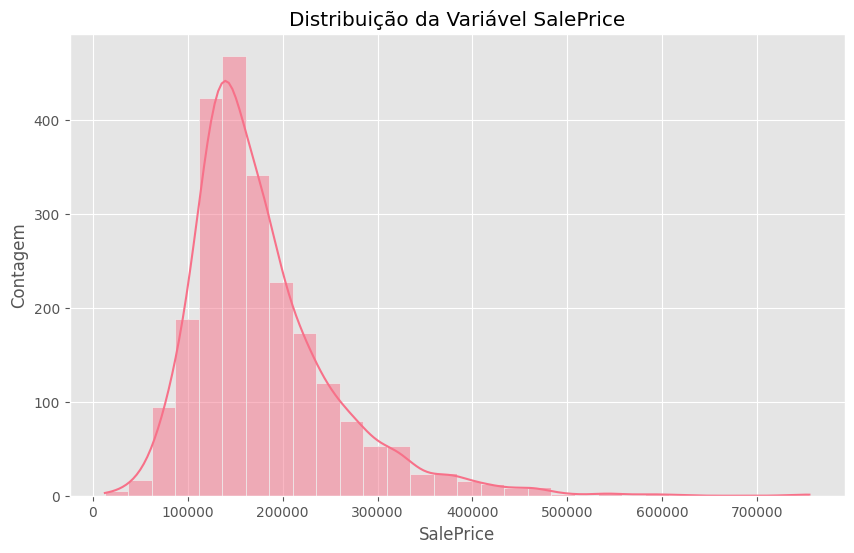

In [9]:
# 3. Data analysis
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], bins=30, kde=True)
plt.title('Distribuição da Variável SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Contagem')
plt.show()

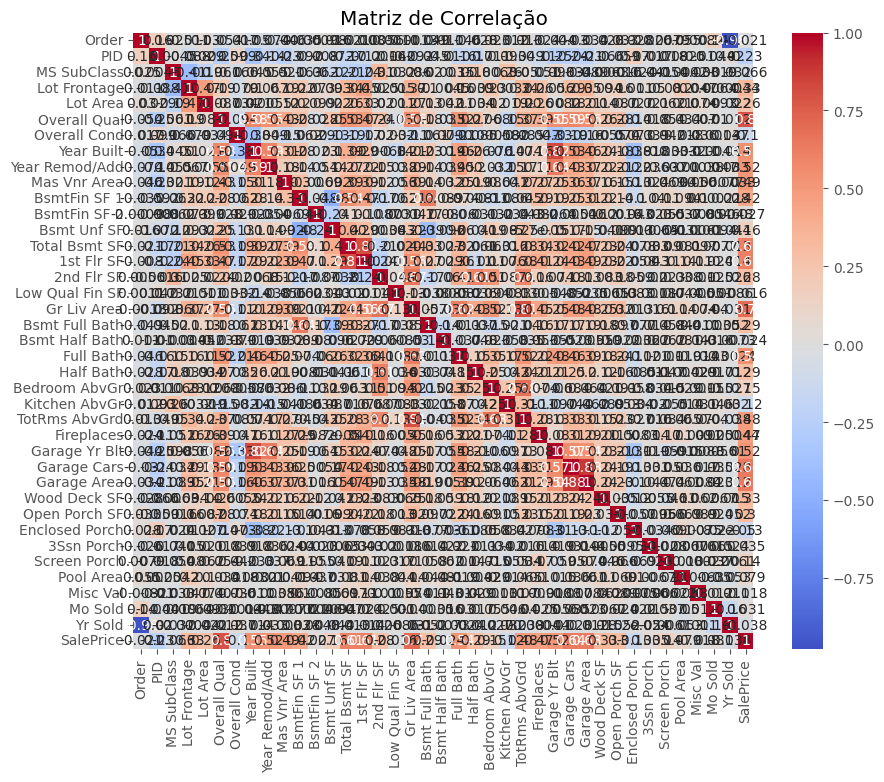

In [10]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

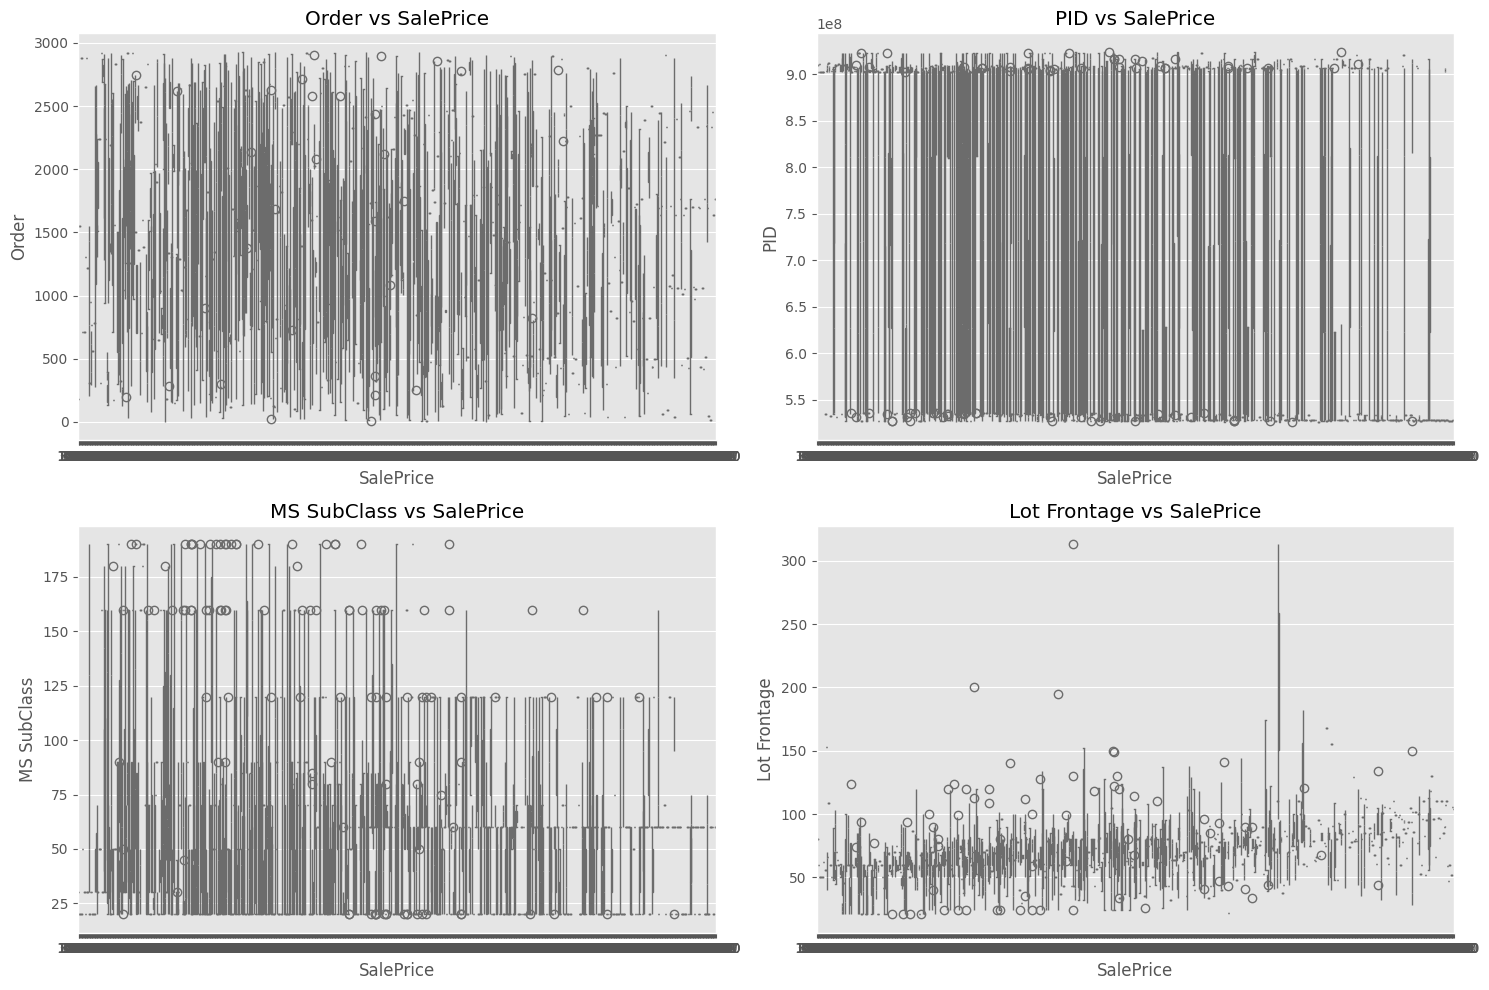

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
numeric_features = [col for col in numeric_cols if col != 'target'][:4]

for i, feature in enumerate(numeric_features):
    row, col = i // 2, i % 2
    sns.boxplot(x='SalePrice', y=feature, data=train_df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs SalePrice')

plt.tight_layout()
plt.show()

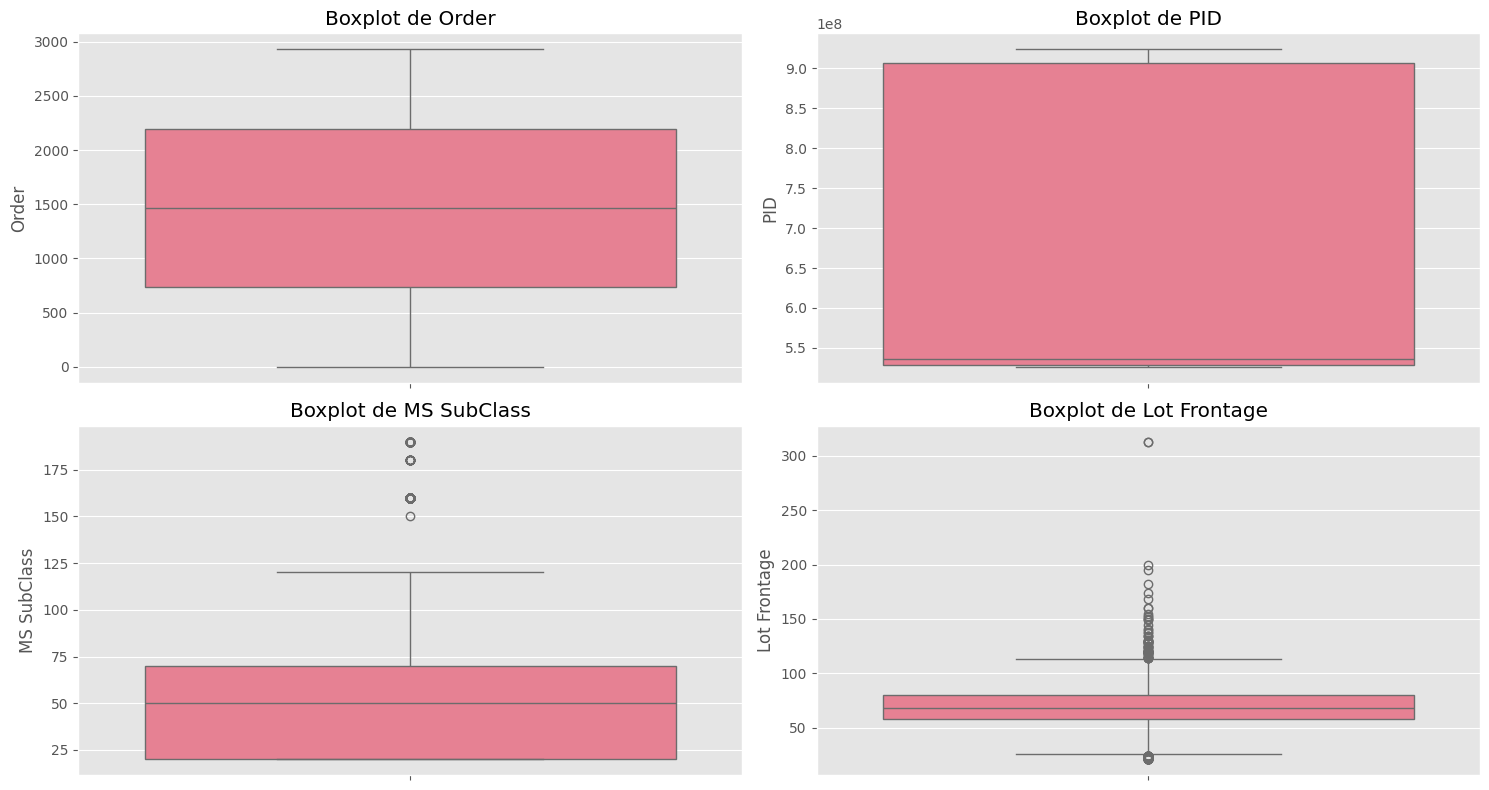

In [13]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=train_df[col])
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

In [ ]:
# 4. Preprocessing
X = train_df.drop('target', axis=1)
y = train_df['target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Variáveis numéricas: {list(numeric_features)}")
print(f"Variáveis categóricas: {list(categorical_features)}")

In [ ]:
# Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif, k='all')),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
# 5. Train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

full_pipeline.fit(X_train, y_train)

In [ ]:
y_pred = full_pipeline.predict(X_val)
y_pred_proba = full_pipeline.predict_proba(X_val)[:, 1]

print("Métricas de Avaliação:")
print(f"Acurácia: {accuracy_score(y_val, y_pred):.4f}")
print(f"Precisão: {precision_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba):.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_val, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# 6. Hyperparameter Optimization
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'feature_selector__k': ['all', 10]
}

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

In [ ]:
print("Melhores parâmetros:")
print(grid_search.best_params_)

print(f"Melhor score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

In [ ]:
# 7. Test differents models
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Cross validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    results[name] = cv_scores.mean()
    print(f"{name}: AUC = {cv_scores.mean():.4f}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Comparação de Modelos (AUC Score)')
plt.xticks(rotation=45)
plt.ylabel('AUC Score')
plt.show()

In [ ]:
# 8. Prediction
test_predictions = best_model.predict(test_df)
test_probabilities = best_model.predict_proba(test_df)[:, 1]

submission_df = pd.DataFrame({
    'id': test_df.index,
    'target_pred': test_predictions,
    'target_probability': test_probabilities
})

In [ ]:
submission_df.to_csv('predicoes.csv', index=False)
print("Predições salvas em 'predicoes.csv'")

joblib.dump(best_model, 'modelo_treinado.pkl')
print("Modelo salvo em 'modelo_treinado.pkl'")

In [ ]:
preprocessing_info = {
    'numeric_features': list(numeric_features),
    'categorical_features': list(categorical_features)
}

with open('preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f)

print("Informações de pré-processamento salvas")